### Importación de librerías

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier


plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')


### Carga y exploración inicial de los datos

       Application order  Daytime/evening attendance  \
count        6700.000000                 6700.000000   
mean            1.640299                    0.867910   
std             1.210069                    0.338613   
min             0.000000                    0.000000   
25%             1.000000                    1.000000   
50%             1.000000                    1.000000   
75%             2.000000                    1.000000   
max             9.000000                    1.000000   

       Previous qualification (grade)  Admission grade    Displaced  \
count                     6700.000000      6700.000000  6700.000000   
mean                       132.272836       126.435254     0.481493   
std                         12.785551        14.180613     0.499695   
min                         95.000000        95.000000     0.000000   
25%                        124.000000       117.479396     0.000000   
50%                        133.000000       125.419398     0.000000  

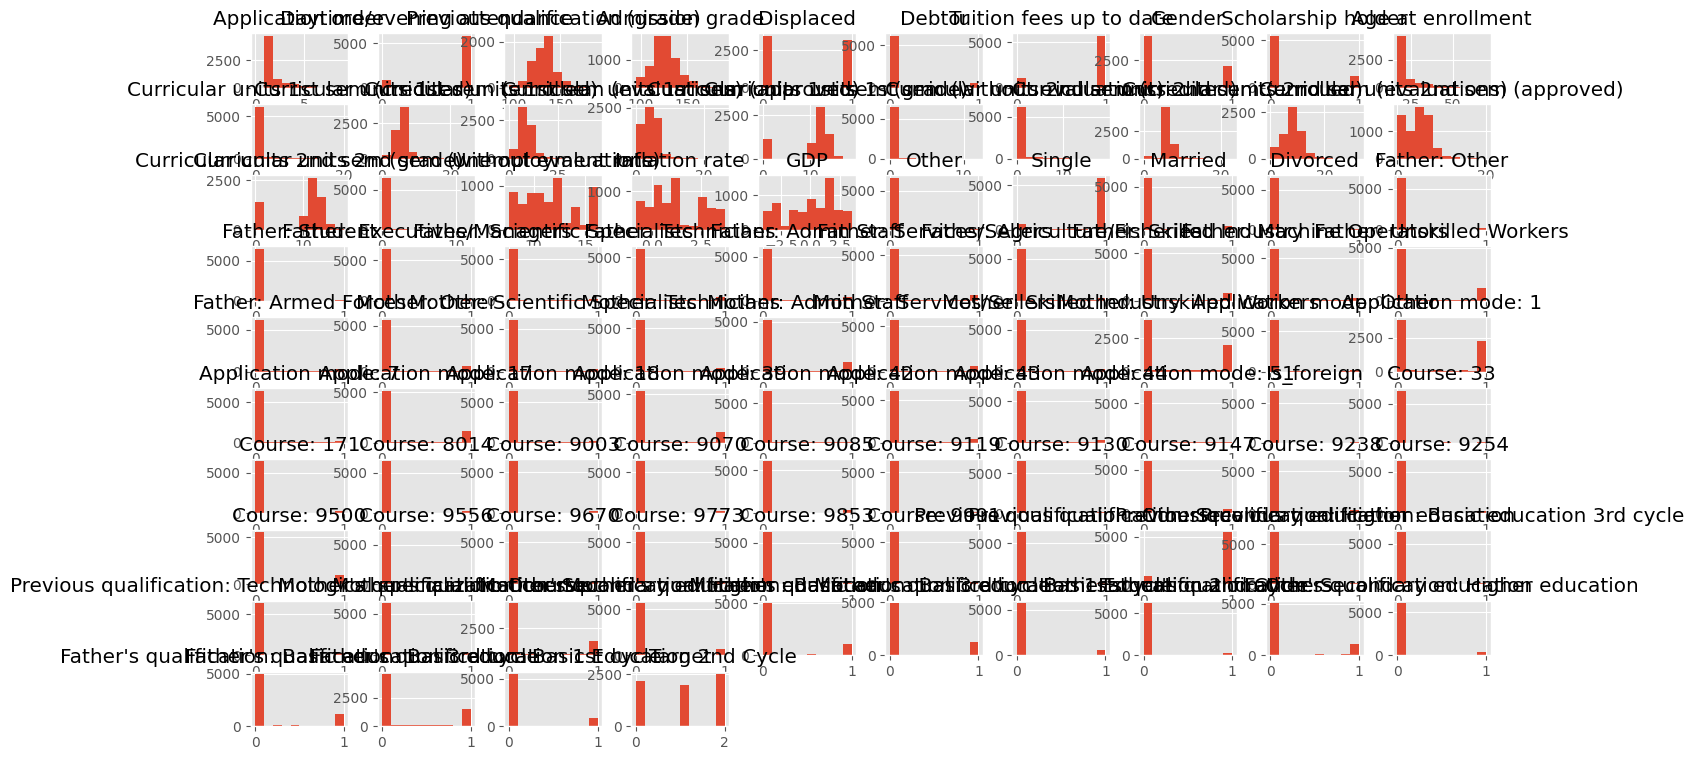

In [28]:
df = pd.read_csv("data_resampled.csv")
print(df.describe())
df.hist()
plt.show()

### Preprocesamiento: codificación, separación y escalado

In [29]:
X = df.drop(columns=['Target'])
y = df['Target']

label_encoders = {}
for column in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column].astype(str))
    label_encoders[column] = le

y_le = LabelEncoder()
y_encoded = y_le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=0)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Búsqueda del mejor k y entrenamiento del modelo

In [39]:
from sklearn.model_selection import GridSearchCV

# --- GridSearchCV para encontrar la mejor combinación ---
param_grid = {
    'n_neighbors': range(1, 21),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_scaled, y_train)

print("Mejor combinación:", grid.best_params_)

# --- Entrenar el modelo final con la mejor combinación ---
best_model = grid.best_estimator_

# Accuracy final
train_acc = best_model.score(X_train_scaled, y_train)
test_acc = best_model.score(X_test_scaled, y_test)
print(f"Train accuracy: {train_acc:.2f}")
print(f"Test accuracy: {test_acc:.2f}")

#la mejor K es:
best_k = grid.best_params_['n_neighbors']
print(f"Mejor K: {best_k}")



"""#las otras metricas tienen las siguientes combinaciones y accuracies:

combinaciones = grid.cv_results_['params']
scores = grid.cv_results_['mean_test_score']
for i in range(len(combinaciones)):
    print(f"Combinación: {combinaciones[i]}, Accuracy: {scores[i]:.2f}")

#grafico de accuracies
plt.figure(figsize=(10, 6))
plt.plot(scores, marker='o')
plt.title('Accuracy por combinación de hiperparámetros')
plt.xlabel('Combinación')
plt.ylabel('Accuracy')
plt.xticks(range(len(combinaciones)), [str(comb) for comb in combinaciones], rotation=90)
plt.grid()
plt.tight_layout()
plt.show()
"""



Mejor combinación: {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}
Train accuracy: 1.00
Test accuracy: 0.81
Mejor K: 4


'#las otras metricas tienen las siguientes combinaciones y accuracies:\n\ncombinaciones = grid.cv_results_[\'params\']\nscores = grid.cv_results_[\'mean_test_score\']\nfor i in range(len(combinaciones)):\n    print(f"Combinación: {combinaciones[i]}, Accuracy: {scores[i]:.2f}")\n\n#grafico de accuracies\nplt.figure(figsize=(10, 6))\nplt.plot(scores, marker=\'o\')\nplt.title(\'Accuracy por combinación de hiperparámetros\')\nplt.xlabel(\'Combinación\')\nplt.ylabel(\'Accuracy\')\nplt.xticks(range(len(combinaciones)), [str(comb) for comb in combinaciones], rotation=90)\nplt.grid()\nplt.tight_layout()\nplt.show()\n'

Matriz de confusión:
[[329  40  73]
 [ 10 344  50]
 [ 28  56 410]]
              precision    recall  f1-score   support

           0       0.90      0.74      0.81       442
           1       0.78      0.85      0.82       404
           2       0.77      0.83      0.80       494

    accuracy                           0.81      1340
   macro avg       0.82      0.81      0.81      1340
weighted avg       0.81      0.81      0.81      1340



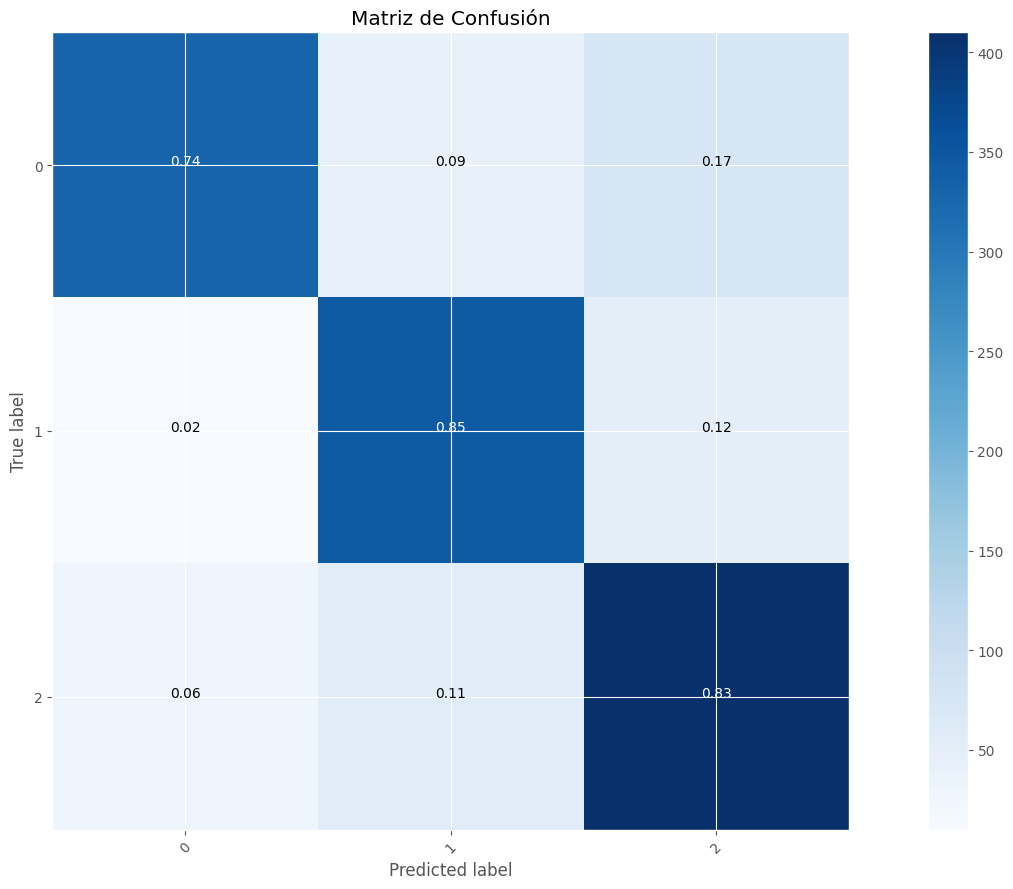

In [31]:
#matriz de confusión con la mejor combinación
y_pred = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
print(cm)
print(classification_report(y_test, y_pred, target_names=[str(cls) for cls in y_le.classes_]))
# --- Visualización de la matriz de confusión ---
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Normalizar la matriz de confusión
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized[np.isnan(cm_normalized)] = 0

    thresh = cm_normalized.max() / 2.
    for i, j in np.ndindex(cm_normalized.shape):
        plt.text(j, i, f"{cm_normalized[i, j]:.2f}",
                 horizontalalignment="center",
                 color="white" if cm_normalized[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
plot_confusion_matrix(cm, classes=y_le.classes_, title='Matriz de Confusión')
plt.show()


### Evaluación del modelo

[[329  40  73]
 [ 10 344  50]
 [ 28  56 410]]
              precision    recall  f1-score   support

           0       0.90      0.74      0.81       442
           1       0.78      0.85      0.82       404
           2       0.77      0.83      0.80       494

    accuracy                           0.81      1340
   macro avg       0.82      0.81      0.81      1340
weighted avg       0.81      0.81      0.81      1340



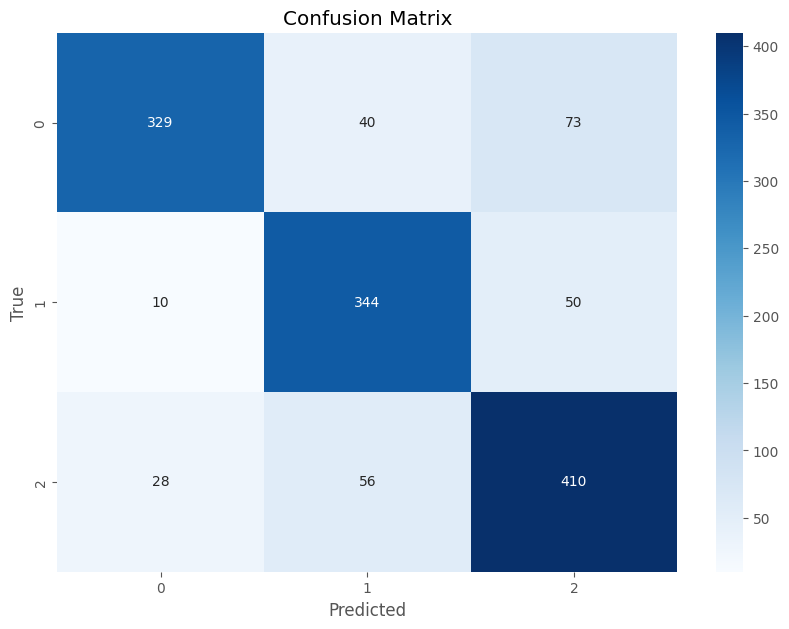

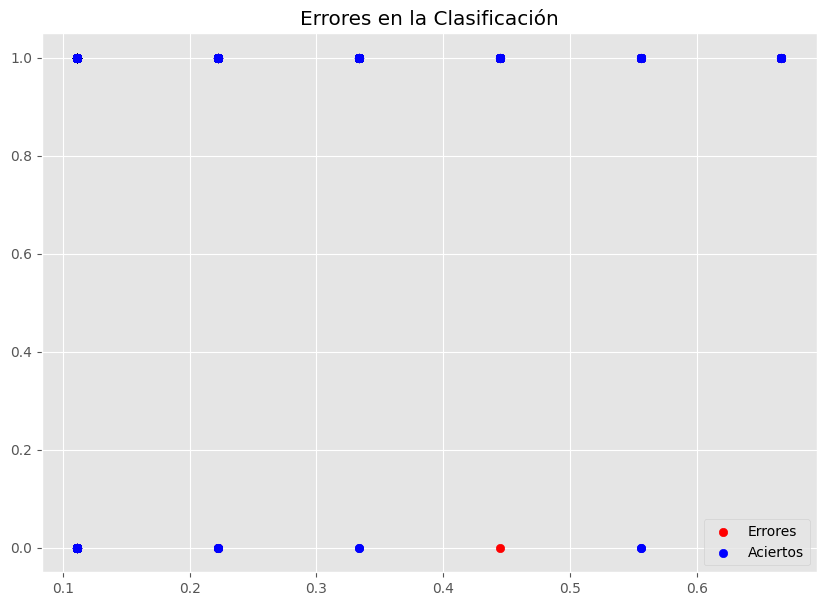

In [32]:
y_pred = best_model.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=[str(cls) for cls in y_le.classes_]))


# Matriz de confusión
plt.figure(figsize=(10, 7))
sb.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
           xticklabels=y_le.classes_, yticklabels=y_le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Errores
errors = (y_test != y_pred)
plt.figure(figsize=(10, 7))
plt.scatter(X_test_scaled[errors, 0], X_test_scaled[errors, 1], c='red', label='Errores')
plt.scatter(X_test_scaled[~errors, 0], X_test_scaled[~errors, 1], c='blue', label='Aciertos')
plt.title('Errores en la Clasificación')
plt.legend()
plt.show()


 ### Visualización 2D de la clasificación y predicciones nuevas

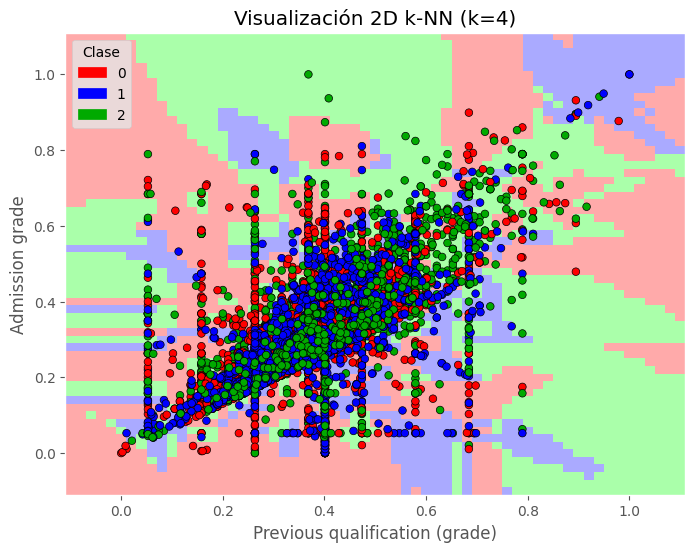

In [33]:
def plot_decision_boundary(model, X, y, feature_names, title, nuevos=None, predicciones=None):
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF', '#AAFFAA'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF', '#00AA00'])

    plt.figure(figsize=(8, 6))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=30)

    if nuevos is not None:
        plt.scatter(nuevos[:, 0], nuevos[:, 1], c='black', marker='x', s=100, label='Predicciones')
        for i, label in enumerate(predicciones):
            plt.annotate(f"Predicción: {label}", (nuevos[i, 0], nuevos[i, 1]), textcoords="offset points",
                         xytext=(0, 10), ha='center', fontsize=8)

    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title(title)
    handles = [mpatches.Patch(color=cmap_bold(i), label=lbl) for i, lbl in enumerate(y_le.classes_)]
    if nuevos is not None:
        handles.append(mpatches.Patch(color='black', label='Predicciones'))
    plt.legend(handles=handles, title="Clase")
    plt.show()

# %%
# Elegir dos características
features = ['Previous qualification (grade)', 'Admission grade']
X_vis = df[features]
X_vis_scaled = scaler.fit_transform(X_vis)
y_vis = y_le.transform(df['Target'])

# Entrenar modelo sobre estas 2 características
model_vis = KNeighborsClassifier(n_neighbors=best_k)
model_vis.fit(X_vis_scaled, y_vis)

# Plot sin nuevos puntos
plot_decision_boundary(model_vis, X_vis_scaled, y_vis, features, f'Visualización 2D k-NN (k={best_k})')


### Predicción de nuevos puntos y visualización

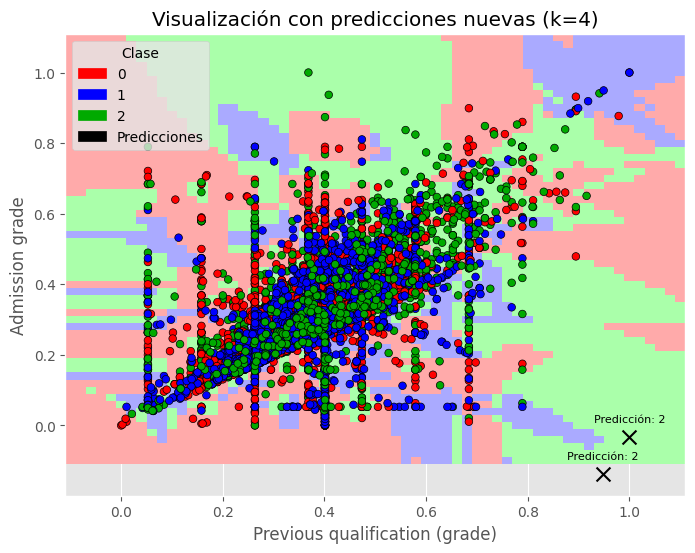

In [37]:

nuevo_df = pd.DataFrame({
    'Previous qualification (grade)': [185, 190],
    'Admission grade': [82, 92]
})

X_nuevo_plot = nuevo_df[features]
X_nuevo_scaled = scaler.transform(X_nuevo_plot)
predicciones_nuevo = model_vis.predict(X_nuevo_scaled)
predicciones_labels = y_le.inverse_transform(predicciones_nuevo)

# Plot con nuevos puntos
plot_decision_boundary(model_vis, X_vis_scaled, y_vis, features, 
                       f'Visualización con predicciones nuevas (k={best_k})',
                       nuevos=X_nuevo_scaled, predicciones=predicciones_labels)


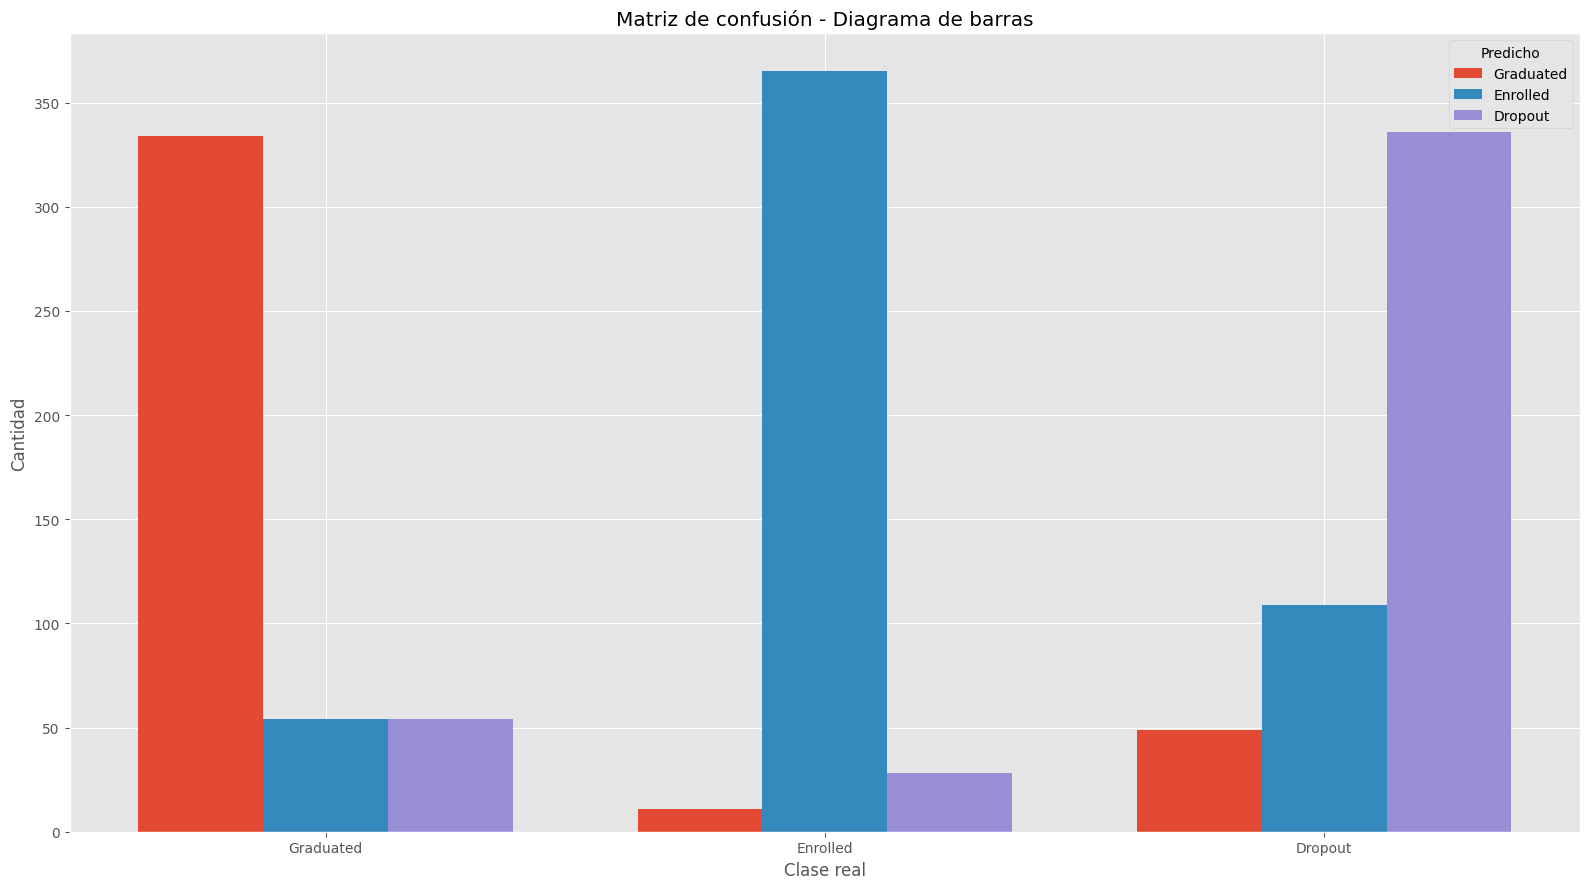

In [35]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['Graduated', 'Enrolled', 'Dropout']
predicted_labels = ['Graduated', 'Enrolled', 'Dropout']
conf_matrix = np.array([
    [334, 54, 54],
    [11, 365, 28],
    [49, 109, 336]
])

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
for i in range(3):
    ax.bar(x + i*width, conf_matrix[:, i], width, label=predicted_labels[i])

ax.set_xlabel('Clase real')
ax.set_ylabel('Cantidad')
ax.set_title('Matriz de confusión - Diagrama de barras')
ax.set_xticks(x + width)
ax.set_xticklabels(labels)
ax.legend(title="Predicho")

plt.tight_layout()
plt.show()


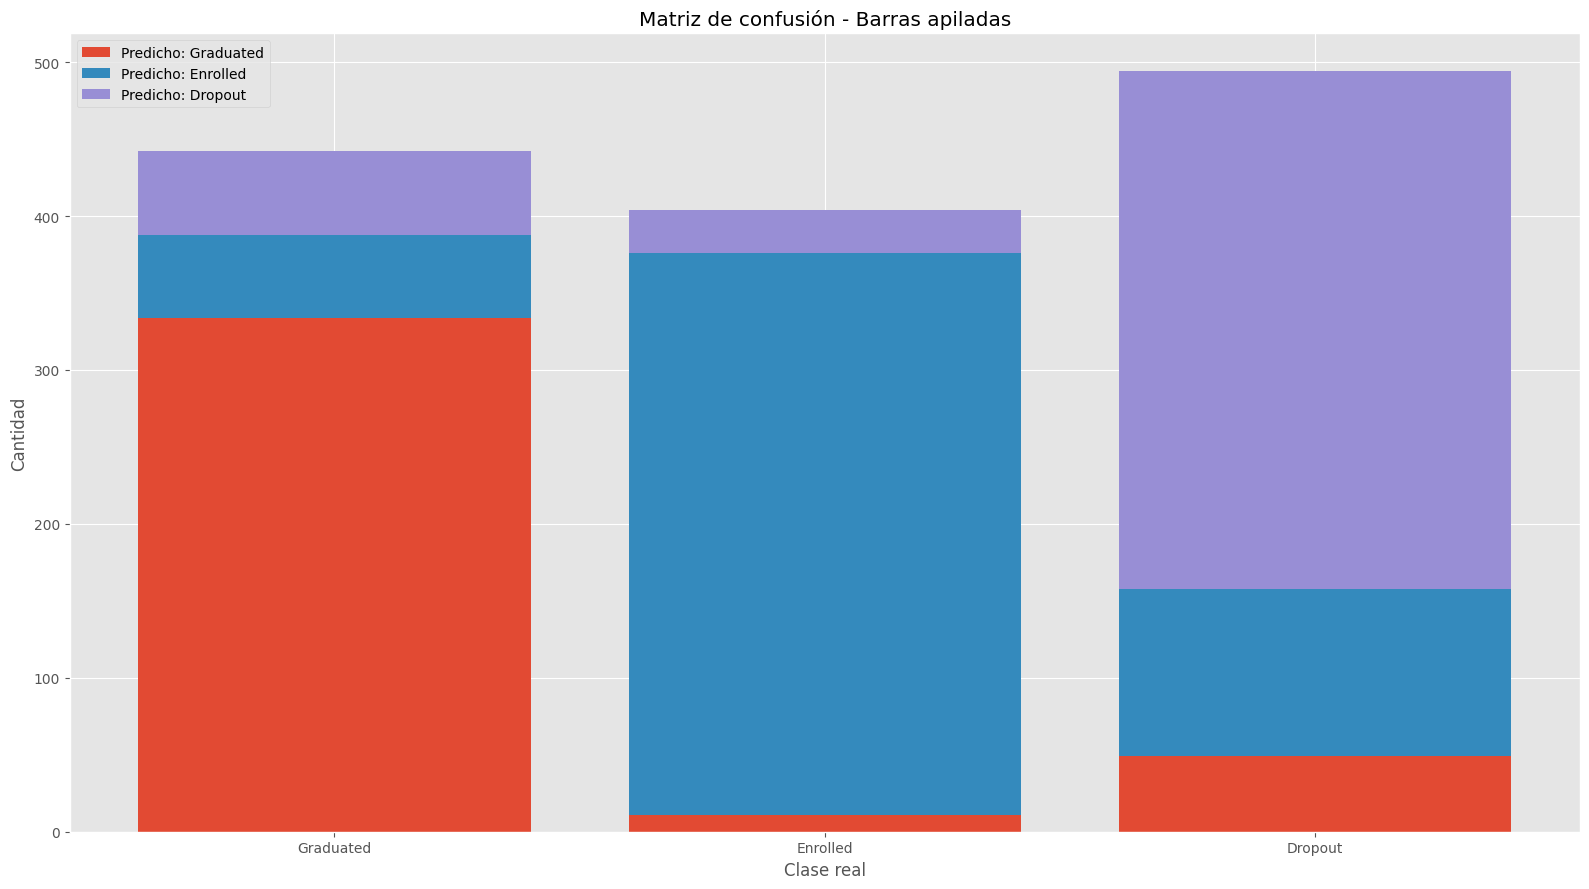

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Etiquetas
labels = ['Graduated', 'Enrolled', 'Dropout']
# Matriz de confusión
conf_matrix = np.array([
    [334, 54, 54],
    [11, 365, 28],
    [49, 109, 336]
])

# Separar las columnas para apilar
graduated_pred = conf_matrix[:, 0]
enrolled_pred = conf_matrix[:, 1]
dropout_pred = conf_matrix[:, 2]

# Eje X
x = np.arange(len(labels))

# Gráfico
plt.bar(x, graduated_pred, label='Predicho: Graduated')
plt.bar(x, enrolled_pred, bottom=graduated_pred, label='Predicho: Enrolled')
plt.bar(x, dropout_pred, bottom=graduated_pred + enrolled_pred, label='Predicho: Dropout')

plt.xticks(x, labels)
plt.xlabel('Clase real')
plt.ylabel('Cantidad')
plt.title('Matriz de confusión - Barras apiladas')
plt.legend()

plt.tight_layout()
plt.show()
